In [1]:
import pandas as pd
import string
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import pattern
from pattern.en import lemma

from gensim.models import Word2Vec

import numpy as np
import re

from sklearn.model_selection import KFold, cross_val_score, train_test_split
import matplotlib.pyplot as plt

In [2]:
review_df = pd.read_csv('Review_Data.csv')
stop_words = set(stopwords.words('english'))

In [3]:
review_df.head()

,asin,title,review,star
0,B0855T8JT2,\n\n\n\n\n\n\n\n \n \n Poor call quality ...,\n\n\n\n\n\n\n\n\n\n \n \n \n Got these ...,3.0
1,B0855T8JT2,\n\n\n\n\n\n\n\n \n \n Sound Output\n \n,\n\n\n\n\n\n\n\n\n\n \n \n \n Music qual...,5.0
2,B0855T8JT2,\n\n\n\n\n\n\n\n \n \n Wonderful\n \n,\n\n\n\n\n\n\n\n\n\n \n \n \n I was a bi...,5.0
3,B0855T8JT2,\n\n\n\n\n\n\n\n \n \n Hi\n \n,\n\n\n\n\n\n\n\n\n\n \n \n \n Hi\n\n \n,4.0
4,B0855T8JT2,\n\n\n\n\n\n\n\n \n \n Best earbuds for 5...,\n\n\n\n\n\n\n\n\n\n \n \n \n The produc...,5.0


In [4]:
cols = ['title', 'review']
review_df['combined'] = review_df[cols].apply(lambda row: '\n'.join(row.values.astype(str)), axis=1)
review_df.drop(['title','review'],axis = 1,inplace = True)
review_df.head()

,asin,star,combined
0,B0855T8JT2,3.0,\n\n\n\n\n\n\n\n \n \n Poor call quality ...
1,B0855T8JT2,5.0,\n\n\n\n\n\n\n\n \n \n Sound Output\n \n...
2,B0855T8JT2,5.0,\n\n\n\n\n\n\n\n \n \n Wonderful\n \n\n\...
3,B0855T8JT2,4.0,\n\n\n\n\n\n\n\n \n \n Hi\n \n\n\n\n\n\n...
4,B0855T8JT2,5.0,\n\n\n\n\n\n\n\n \n \n Best earbuds for 5...


In [5]:
def clean_data(stri):
    
    sent_lst = []
    for sent in sent_tokenize(stri):
        lst = []
        for word in word_tokenize(sent):
            if(word.isalpha() and len(word)>1):
                lst.append(word.lower())
        clean_sent = ' '.join(lst)
        sent_lst.append(clean_sent)

    return sent_lst

In [6]:
review_df['combined'] = review_df['combined'].apply(lambda x: clean_data(x))

In [7]:
review_df.head()

,asin,star,combined
0,B0855T8JT2,3.0,[poor call quality had to return got these ear...
1,B0855T8JT2,5.0,[sound output music quality is way better than...
2,B0855T8JT2,5.0,[wonderful was bit skeptical while buying it b...
3,B0855T8JT2,4.0,[hi hi]
4,B0855T8JT2,5.0,[best earbuds for rs the product feels very pr...


In [8]:
review_df['combined'][0]

['poor call quality had to return got these earphones after long research',
 'the online reviews focus mostly on the sound quality',
 'these buds perform well in that department',
 'dual drivers deliver good and loud output',
 'the case is made up of soft touch plastic',
 'the magnetic buds snap in perfectly',
 'no complaints on design and build these fail miserably is the microphone department',
 'had to write this review so that others buy these with this point in mind',
 'could not find any detailed review on the call quality for which had to suffer',
 'calls sound muffled through these mics',
 'the person on the other end always had complaints regarding the sound in quiet or noisy environment was sounding really bad',
 'personally heard it by pairing it to someone else phone the microphones are truly would like to comment on the fit they are okay but will not provide too much of passive noise what the deal with free movie vouches for posting review on amazon',
 'are you kidding me 

In [9]:
review_df['star'].value_counts()

5.0    1082
1.0     706
4.0     444
3.0     289
2.0     234
Name: star, dtype: int64

In [10]:
def update_star(star):
    if star == 5:
        return 1
    elif star in [3,4]:
        return 0
    else:
        return -1

review_df['star'] = review_df['star'].apply(lambda x: update_star(x))

review_df['star'].value_counts()

 1    1082
-1     940
 0     733
Name: star, dtype: int64

In [11]:
#Import packages
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

## Exapmple document (list of sentences)
doc = list(review_df['combined'].values)

# Tokenization of each document
tokenized_doc = []
for d in doc:
    for i in d:
        tokenized_doc.append(word_tokenize(i.lower()))
tokenized_doc

[['poor',
  'call',
  'quality',
  'had',
  'to',
  'return',
  'got',
  'these',
  'earphones',
  'after',
  'long',
  'research'],
 ['the',
  'online',
  'reviews',
  'focus',
  'mostly',
  'on',
  'the',
  'sound',
  'quality'],
 ['these', 'buds', 'perform', 'well', 'in', 'that', 'department'],
 ['dual', 'drivers', 'deliver', 'good', 'and', 'loud', 'output'],
 ['the', 'case', 'is', 'made', 'up', 'of', 'soft', 'touch', 'plastic'],
 ['the', 'magnetic', 'buds', 'snap', 'in', 'perfectly'],
 ['no',
  'complaints',
  'on',
  'design',
  'and',
  'build',
  'these',
  'fail',
  'miserably',
  'is',
  'the',
  'microphone',
  'department'],
 ['had',
  'to',
  'write',
  'this',
  'review',
  'so',
  'that',
  'others',
  'buy',
  'these',
  'with',
  'this',
  'point',
  'in',
  'mind'],
 ['could',
  'not',
  'find',
  'any',
  'detailed',
  'review',
  'on',
  'the',
  'call',
  'quality',
  'for',
  'which',
  'had',
  'to',
  'suffer'],
 ['calls', 'sound', 'muffled', 'through', 'these', 

In [12]:
# Convert tokenized document into gensim formated tagged data
tagged_data = [TaggedDocument(d, [i]) for i, d in enumerate(tokenized_doc)]
tagged_data

[TaggedDocument(words=['poor', 'call', 'quality', 'had', 'to', 'return', 'got', 'these', 'earphones', 'after', 'long', 'research'], tags=[0]),
 TaggedDocument(words=['the', 'online', 'reviews', 'focus', 'mostly', 'on', 'the', 'sound', 'quality'], tags=[1]),
 TaggedDocument(words=['these', 'buds', 'perform', 'well', 'in', 'that', 'department'], tags=[2]),
 TaggedDocument(words=['dual', 'drivers', 'deliver', 'good', 'and', 'loud', 'output'], tags=[3]),
 TaggedDocument(words=['the', 'case', 'is', 'made', 'up', 'of', 'soft', 'touch', 'plastic'], tags=[4]),
 TaggedDocument(words=['the', 'magnetic', 'buds', 'snap', 'in', 'perfectly'], tags=[5]),
 TaggedDocument(words=['no', 'complaints', 'on', 'design', 'and', 'build', 'these', 'fail', 'miserably', 'is', 'the', 'microphone', 'department'], tags=[6]),
 TaggedDocument(words=['had', 'to', 'write', 'this', 'review', 'so', 'that', 'others', 'buy', 'these', 'with', 'this', 'point', 'in', 'mind'], tags=[7]),
 TaggedDocument(words=['could', 'not', '

In [13]:
## Train doc2vec model
model = Doc2Vec(tagged_data, vector_size=20, window=2, min_count=1, workers=4, epochs = 100)
# Save trained doc2vec model
model.save("test_doc2vec.model")
## Load saved doc2vec model
model= Doc2Vec.load("test_doc2vec.model")
## Print model vocabulary
model.wv.vocab

{'poor': <gensim.models.keyedvectors.Vocab at 0x27c9cf95670>,
 'call': <gensim.models.keyedvectors.Vocab at 0x27c9cf956a0>,
 'quality': <gensim.models.keyedvectors.Vocab at 0x27c9cf956d0>,
 'had': <gensim.models.keyedvectors.Vocab at 0x27c9cf95f10>,
 'to': <gensim.models.keyedvectors.Vocab at 0x27c9cf957f0>,
 'return': <gensim.models.keyedvectors.Vocab at 0x27c9cf95fd0>,
 'got': <gensim.models.keyedvectors.Vocab at 0x27c9cf95790>,
 'these': <gensim.models.keyedvectors.Vocab at 0x27c9cf959a0>,
 'earphones': <gensim.models.keyedvectors.Vocab at 0x27c9cf95c10>,
 'after': <gensim.models.keyedvectors.Vocab at 0x27c9cf959d0>,
 'long': <gensim.models.keyedvectors.Vocab at 0x27c9cf95910>,
 'research': <gensim.models.keyedvectors.Vocab at 0x27c9cf95970>,
 'the': <gensim.models.keyedvectors.Vocab at 0x27c9cf95b80>,
 'online': <gensim.models.keyedvectors.Vocab at 0x27c9cf95df0>,
 'reviews': <gensim.models.keyedvectors.Vocab at 0x27c9cf95bb0>,
 'focus': <gensim.models.keyedvectors.Vocab at 0x27c9c

In [14]:
model.wv.most_similar('good')

[('decent', 0.9665875434875488),
 ('great', 0.9190833568572998),
 ('nice', 0.912090539932251),
 ('awesome', 0.9101192951202393),
 ('ok', 0.9065324068069458),
 ('amazing', 0.8803766965866089),
 ('impressive', 0.866969883441925),
 ('excellent', 0.8603370785713196),
 ('superb', 0.8513860106468201),
 ('bad', 0.8474864959716797)]

In [15]:
model['great']

array([-0.7261077 ,  0.33786622, -1.5084913 ,  1.6592622 , -1.2441726 ,
       -1.3819581 , -0.71070033,  1.3401134 , -1.4024796 , -0.17874058,
        1.3262792 , -0.12091357,  0.13961506,  0.70598876, -0.31641635,
       -0.66201234,  0.7162875 , -0.6331617 ,  0.20626423,  1.7419354 ],
      dtype=float32)

In [16]:
list(model.wv.vocab)

['poor',
 'call',
 'quality',
 'had',
 'to',
 'return',
 'got',
 'these',
 'earphones',
 'after',
 'long',
 'research',
 'the',
 'online',
 'reviews',
 'focus',
 'mostly',
 'on',
 'sound',
 'buds',
 'perform',
 'well',
 'in',
 'that',
 'department',
 'dual',
 'drivers',
 'deliver',
 'good',
 'and',
 'loud',
 'output',
 'case',
 'is',
 'made',
 'up',
 'of',
 'soft',
 'touch',
 'plastic',
 'magnetic',
 'snap',
 'perfectly',
 'no',
 'complaints',
 'design',
 'build',
 'fail',
 'miserably',
 'microphone',
 'write',
 'this',
 'review',
 'so',
 'others',
 'buy',
 'with',
 'point',
 'mind',
 'could',
 'not',
 'find',
 'any',
 'detailed',
 'for',
 'which',
 'suffer',
 'calls',
 'muffled',
 'through',
 'mics',
 'person',
 'other',
 'end',
 'always',
 'regarding',
 'quiet',
 'or',
 'noisy',
 'environment',
 'was',
 'sounding',
 'really',
 'bad',
 'personally',
 'heard',
 'it',
 'by',
 'pairing',
 'someone',
 'else',
 'phone',
 'microphones',
 'are',
 'truly',
 'would',
 'like',
 'comment',
 'fit

In [17]:
X = []
for rev in review_df['combined']:
    lst = []
    n = 0
    for line in rev:
        for word in word_tokenize(line):
            lst.append(model[word])
            n = n+1
    lst = np.array(lst)
    X.append([np.sum(lst[:,i])/n for i in range(20)])

In [18]:
X = np.array(X)

In [19]:
review_df.shape

(2755, 3)

In [20]:
np.shape(X)

(2755, 20)

In [21]:
y = review_df['star'].ravel()

X_train,X_valid,y_train,y_valid = train_test_split(X,y,test_size=0.3,random_state=17)

In [22]:
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
import numpy as np

def cross_val(model,X,y):
       
    f1_scr = []
    
    rfk = KFold(n_splits=3, random_state=None,shuffle = True)
    
    for train, test in rfk.split(X): ## you must do this on full dataset 
        print
        try:
            X_train = X.iloc[train]
            X_test = X.iloc[test]
            
        except:
            X_train = X[train,:]
            X_test = X[test,:]
                        
        y_train = y[train]
        y_test = y[test]
        
        model.fit(X_train,y_train)
        y_pred = model.predict(X_test)
        f1 = f1_score(y_test, y_pred,average = 'micro')
        f1_scr.append(f1)
    print('F1 Score',np.mean(f1_scr))
                    
    return model

In [23]:
from sklearn import metrics

def pred(model,X,y):
    y_pred = model.predict(X)
    f1 = f1_score(y, y_pred,average = 'micro')
    print(f1)
    print(metrics.confusion_matrix(y, y_pred))
    print(metrics.classification_report(y, y_pred))

In [24]:
from sklearn.linear_model import LogisticRegression

Log_Reg = LogisticRegression(random_state=0,solver='lbfgs',max_iter = 200)

Log_Reg = cross_val(Log_Reg,X_train,y_train)
pred(Log_Reg,X_valid,y_valid)

F1 Score 0.653520055425551
0.6614268440145102
[[215  42  24]
 [ 57  79  71]
 [ 32  54 253]]
              precision    recall  f1-score   support

          -1       0.71      0.77      0.74       281
           0       0.45      0.38      0.41       207
           1       0.73      0.75      0.74       339

    accuracy                           0.66       827
   macro avg       0.63      0.63      0.63       827
weighted avg       0.65      0.66      0.66       827



In [25]:
from sklearn.tree import DecisionTreeClassifier

DCT_Classifier = DecisionTreeClassifier(criterion='entropy', random_state=1)

DCT_Classifier = cross_val(DCT_Classifier,X_train,y_train)
pred(DCT_Classifier,X_valid,y_valid)

F1 Score 0.576247276767618
0.5985489721886336
[[184  56  41]
 [ 66  87  54]
 [ 39  76 224]]
              precision    recall  f1-score   support

          -1       0.64      0.65      0.65       281
           0       0.40      0.42      0.41       207
           1       0.70      0.66      0.68       339

    accuracy                           0.60       827
   macro avg       0.58      0.58      0.58       827
weighted avg       0.60      0.60      0.60       827



In [26]:
from sklearn.ensemble import RandomForestClassifier

RF_Classifier = cross_val(RandomForestClassifier(),X_train,y_train)
pred(RF_Classifier,X_valid,y_valid)

F1 Score 0.6950326949382196
0.6783555018137848
[[222  32  27]
 [ 58  75  74]
 [ 38  37 264]]
              precision    recall  f1-score   support

          -1       0.70      0.79      0.74       281
           0       0.52      0.36      0.43       207
           1       0.72      0.78      0.75       339

    accuracy                           0.68       827
   macro avg       0.65      0.64      0.64       827
weighted avg       0.66      0.68      0.67       827



In [27]:
from xgboost import XGBClassifier

XGB_Classifier = cross_val(XGBClassifier(),X_train,y_train)
pred(XGB_Classifier,X_valid,y_valid)

F1 Score 0.681021270685665
0.6928657799274486
[[211  49  21]
 [ 45 102  60]
 [ 29  50 260]]
              precision    recall  f1-score   support

          -1       0.74      0.75      0.75       281
           0       0.51      0.49      0.50       207
           1       0.76      0.77      0.76       339

    accuracy                           0.69       827
   macro avg       0.67      0.67      0.67       827
weighted avg       0.69      0.69      0.69       827



In [28]:
from sklearn.svm import SVC

SVM_Classifier = cross_val(SVC(),X_train,y_train)
pred(SVM_Classifier,X_valid,y_valid)

F1 Score 0.6789411975601131
0.6614268440145102
[[214  43  24]
 [ 53  74  80]
 [ 31  49 259]]
              precision    recall  f1-score   support

          -1       0.72      0.76      0.74       281
           0       0.45      0.36      0.40       207
           1       0.71      0.76      0.74       339

    accuracy                           0.66       827
   macro avg       0.63      0.63      0.62       827
weighted avg       0.65      0.66      0.65       827



2 :  0.22626358020631337
3 :  0.1383760817532888
4 :  0.09253456928603919
5 :  0.08518825961501354
6 :  0.09444119847260901
7 :  0.09158794323033857
8 :  0.06180223327739359
9 :  0.06518900166702728
10 :  0.05949042674599852
11 :  0.05565402603742971
12 :  0.06007082893636336
13 :  0.05523220206801718
14 :  0.06079143754487246
15 :  0.06323169905485049
16 :  0.06460924893491475
17 :  0.05649536158327554
18 :  0.060379578719239234
19 :  0.04966709067029383


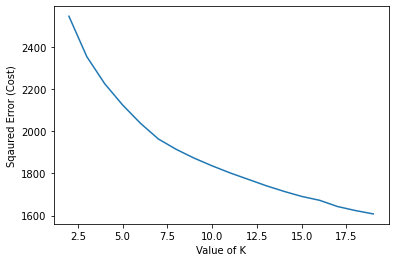

In [29]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

inertia_lst = []
for i in range(2,20):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(X)
    inertia_lst.append(kmeans.inertia_)
    print(i,': ',silhouette_score(X, kmeans.labels_, metric='euclidean'))
    
plt.plot(range(2,20),inertia_lst)
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Cost)") 
plt.show()